In [5]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))


GPU Available: True
GPU Name: Tesla T4


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
DATASET_PATH = "/content/drive/My Drive/CV Task/bottle"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH  = os.path.join(DATASET_PATH, "test")
GT_PATH    = os.path.join(DATASET_PATH, "ground_truth")

In [8]:
import os
print("Train folders:", os.listdir(TRAIN_PATH))
print("Test folders:", os.listdir(TEST_PATH))
print("Ground Truth folders:", os.listdir(GT_PATH))

Train folders: ['good']
Test folders: ['contamination', 'broken_large', 'good', 'broken_small']
Ground Truth folders: ['broken_small', 'broken_large', 'contamination']


In [9]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


In [10]:
class BottleDataset(Dataset):
    def __init__(self, root, transform=None, train=True):
        self.images = []
        self.transform = transform

        if train:  # only good images
            folder_path = os.path.join(root, "good")
            for img_file in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, img_file))
        else:  # all test images
            for folder in os.listdir(root):
                folder_path = os.path.join(root, folder)
                if os.path.isdir(folder_path):
                    for img_file in os.listdir(folder_path):
                        self.images.append(os.path.join(folder_path, img_file))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img_tensor = self.transform(img)
        else:
            img_tensor = torch.tensor(img)

        return img_tensor, img_path


In [11]:
train_dataset = BottleDataset(TRAIN_PATH, transform=train_transform, train=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = BottleDataset(TEST_PATH, transform=test_transform, train=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [12]:
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Remove FC layer, use feature extractor
feature_extractor = nn.Sequential(*list(model.children())[:-1])
feature_extractor = feature_extractor.cuda()
feature_extractor.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 90.7MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [13]:
train_features = []

with torch.no_grad():
    for imgs, _ in train_loader:
        imgs = imgs.cuda()
        feats = feature_extractor(imgs)  # Output: [batch, 512, 1, 1]
        feats = feats.view(feats.size(0), -1)  # Flatten [batch, 512]
        train_features.append(feats.cpu())

train_features = torch.cat(train_features, dim=0)
train_features_np = train_features.numpy()
print("Train features shape:", train_features_np.shape)


Train features shape: (209, 512)


In [14]:
mean_feat = train_features_np.mean(axis=0)
cov_feat = np.cov(train_features_np, rowvar=False)
inv_covmat = np.linalg.pinv(cov_feat)

def mahalanobis_distance(feature):
    delta = feature - mean_feat
    m_dist = np.sqrt(np.dot(np.dot(delta, inv_covmat), delta.T))
    return m_dist


In [15]:
threshold = 3.0  # Tune based on train distribution

anomaly_results = []

with torch.no_grad():
    for imgs, img_paths in test_loader:
        imgs = imgs.cuda()
        feats = feature_extractor(imgs)
        feats = feats.view(feats.size(0), -1).cpu().numpy()

        for i, f in enumerate(feats):
            score = mahalanobis_distance(f)
            label = "DEFECT" if score > threshold else "GOOD"
            anomaly_results.append((img_paths[i], score, label))


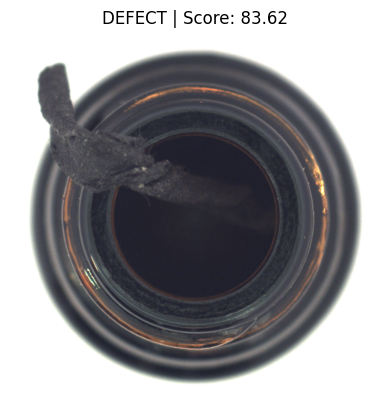

In [16]:
img_path, score, label = anomaly_results[0]
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title(f"{label} | Score: {score:.2f}")
plt.axis("off")
plt.savefig("quality_grades.png", dpi=300, bbox_inches="tight")
plt.show()


In [17]:
# Example: first broken_large mask
mask_path = os.path.join(GT_PATH, "broken_large", os.listdir(GT_PATH+"/broken_large")[0])
mask = cv2.imread(mask_path, 0)

severity = np.sum(mask>0)/mask.size
print("Defect Severity:", severity)

def quality_grade(severity):
    if severity == 0:
        return "ACCEPT"
    elif severity < 0.02:
        return "REWORK"
    else:
        return "REJECT"

print("Quality Grade:", quality_grade(severity))


Defect Severity: 0.13096296296296298
Quality Grade: REJECT


In [18]:
import pandas as pd
from tqdm import tqdm

# Define severity & quality grading function
def quality_grade(severity):
    if severity == 0:
        return "ACCEPT"
    elif severity < 0.02:
        return "REWORK"
    else:
        return "REJECT"

# Initialize results list
results = []

# Batch inference
threshold = 3.0  # anomaly score threshold, tune if needed

for imgs, img_paths in tqdm(test_loader):
    imgs = imgs.cuda()
    with torch.no_grad():
        feats = feature_extractor(imgs)
        feats = feats.view(feats.size(0), -1).cpu().numpy()

    for i, f in enumerate(feats):
        score = mahalanobis_distance(f)
        label = "DEFECT" if score > threshold else "GOOD"

        # Try to load ground truth mask if available for severity
        # Match test folder name with ground_truth folder
        img_name = os.path.basename(img_paths[i])
        folder_name = os.path.basename(os.path.dirname(img_paths[i]))
        mask_path = os.path.join(GT_PATH, folder_name, img_name)
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, 0)
            severity = np.sum(mask>0)/mask.size
        else:
            severity = score / 10  # approximate if no mask available

        grade = quality_grade(severity)

        results.append({
            "Image": img_paths[i],
            "AnomalyScore": score,
            "Label": label,
            "Severity": severity,
            "QualityGrade": grade
        })

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("bottle_test_results.csv", index=False)
print("Batch inference complete. Results saved to bottle_test_results.csv")

100%|██████████| 6/6 [00:03<00:00,  1.94it/s]

Batch inference complete. Results saved to bottle_test_results.csv


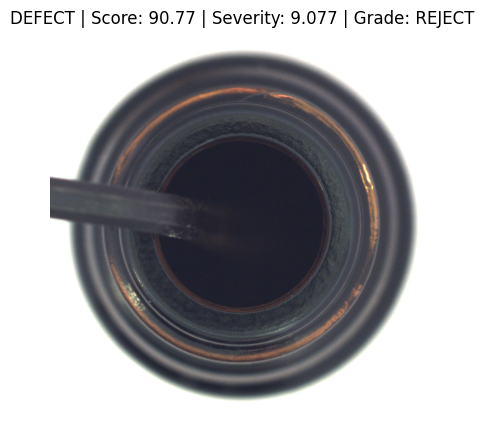

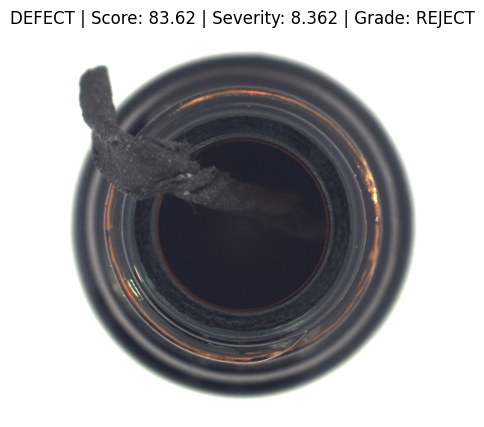

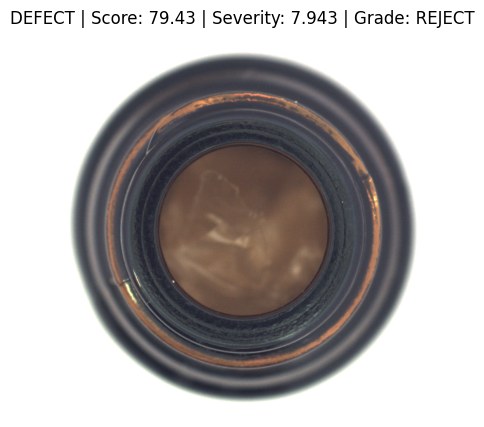

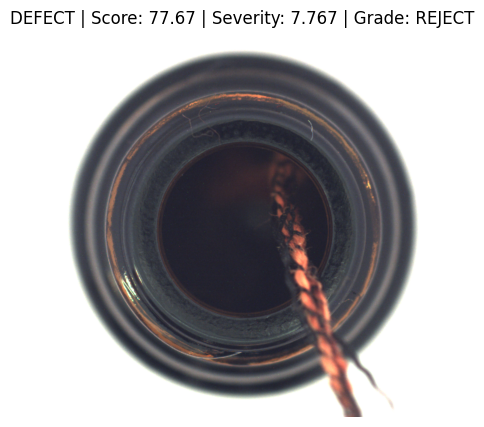

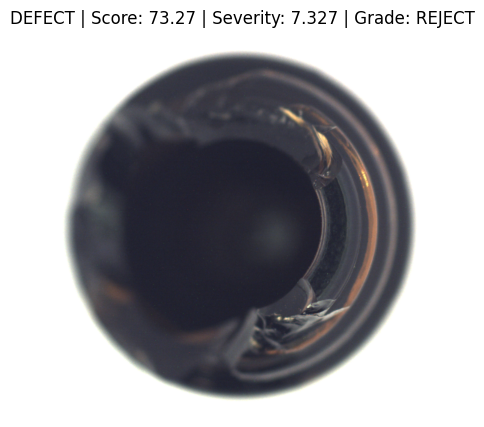

In [19]:
# Show top 5 highest anomaly scores
top_defects = results_df.sort_values(by="AnomalyScore", ascending=False).head(5)

for idx, row in top_defects.iterrows():
    img_path = row['Image']
    label = row['Label']
    score = row['AnomalyScore']
    severity = row['Severity']
    grade = row['QualityGrade']

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.title(f"{label} | Score: {score:.2f} | Severity: {severity:.3f} | Grade: {grade}")
    plt.axis("off")
    plt.show()


===== Test Summary =====
Total Images: 83
GOOD: 0, DEFECT: 83
ACCEPT: 0, REWORK: 0, REJECT: 83


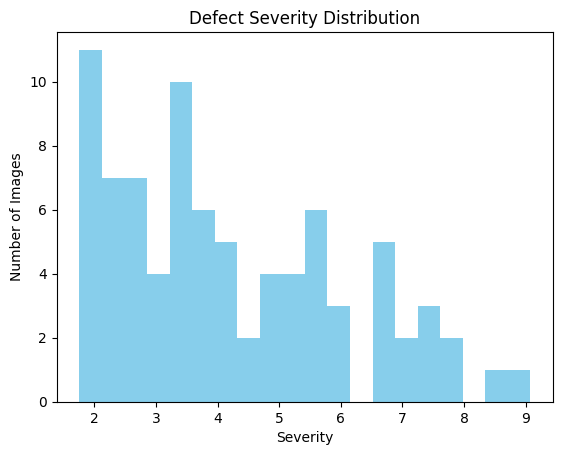

In [20]:
print("===== Test Summary =====")
total_images = len(results_df)
total_defects = len(results_df[results_df['Label']=="DEFECT"])
total_good = len(results_df[results_df['Label']=="GOOD"])
total_accept = len(results_df[results_df['QualityGrade']=="ACCEPT"])
total_rework = len(results_df[results_df['QualityGrade']=="REWORK"])
total_reject = len(results_df[results_df['QualityGrade']=="REJECT"])

print(f"Total Images: {total_images}")
print(f"GOOD: {total_good}, DEFECT: {total_defects}")
print(f"ACCEPT: {total_accept}, REWORK: {total_rework}, REJECT: {total_reject}")

# Optional: visualize distribution of severity
plt.hist(results_df['Severity'], bins=20, color='skyblue')
plt.xlabel("Severity")
plt.ylabel("Number of Images")
plt.title("Defect Severity Distribution")
plt.savefig("defect_severity_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
import torch.nn.functional as F

# Grad-CAM helper function
def generate_heatmap(model, feature_extractor, img_tensor, target_class=None):
    """
    model: full ResNet18
    feature_extractor: truncated ResNet18 (penultimate layers)
    img_tensor: single image tensor [1,3,224,224]
    target_class: 0=GOOD, 1=DEFECT (optional)
    """
    model.eval()

    # Forward pass
    img_tensor = img_tensor.cuda()
    img_tensor.requires_grad = True
    features = feature_extractor(img_tensor)  # [1,512,1,1]

    # For anomaly detection, use L2 norm as score
    score = features.norm()
    score.backward()  # backward to get gradients

    # Gradients
    gradients = img_tensor.grad.data.cpu().numpy()[0]  # [3,224,224]

    # Average gradients over channels
    heatmap = np.mean(gradients, axis=0)

    # Normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


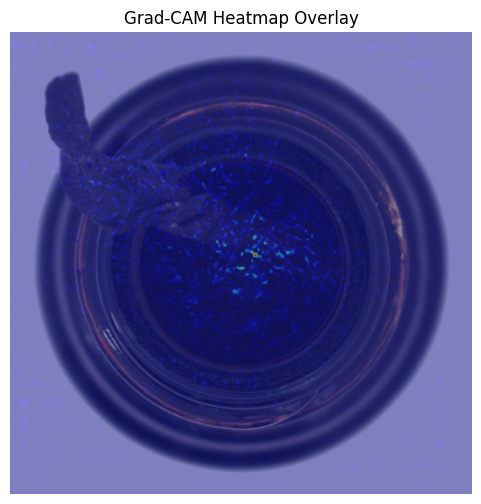

In [22]:
import matplotlib.cm as cm

# Pick a test image
img_path = anomaly_results[0][0]  # first test image
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Prepare tensor
img_tensor = test_transform(img_rgb).unsqueeze(0)

# Generate heatmap
heatmap = generate_heatmap(model, feature_extractor, img_tensor)

# Resize heatmap to image size
heatmap_resized = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))
heatmap_color = cm.jet(heatmap_resized)[:, :, :3]  # convert to RGB

# Overlay heatmap on original image
overlayed = 0.5*img_rgb/255 + 0.5*heatmap_color
overlayed = np.clip(overlayed, 0, 1)

plt.figure(figsize=(6,6))
plt.imshow(overlayed)
plt.title("Grad-CAM Heatmap Overlay")
plt.axis("off")
plt.savefig("Grad_CAM_Heatmap_Overlay.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
import cv2

# Use 0 for default webcam
cap = cv2.VideoCapture(0)

threshold = 3.0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = test_transform(img_rgb).unsqueeze(0).cuda()

    # Feature extraction
    with torch.no_grad():
        feat = feature_extractor(img_tensor)
        feat = feat.view(1, -1).cpu().numpy()[0]
        score = mahalanobis_distance(feat)
        label = "DEFECT" if score > threshold else "GOOD"

    # Optional: Grad-CAM heatmap
    heatmap = generate_heatmap(model, feature_extractor, img_tensor)
    heatmap_resized = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))
    heatmap_color = cm.jet(heatmap_resized)[:, :, :3]
    overlayed = 0.5*frame/255 + 0.5*heatmap_color
    overlayed = np.clip(overlayed, 0, 1)

    cv2.imshow("Defect Detection", overlayed[..., ::-1])  # Convert RGB to BGR for OpenCV
    cv2.putText(frame, f"{label} | Score: {score:.2f}", (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


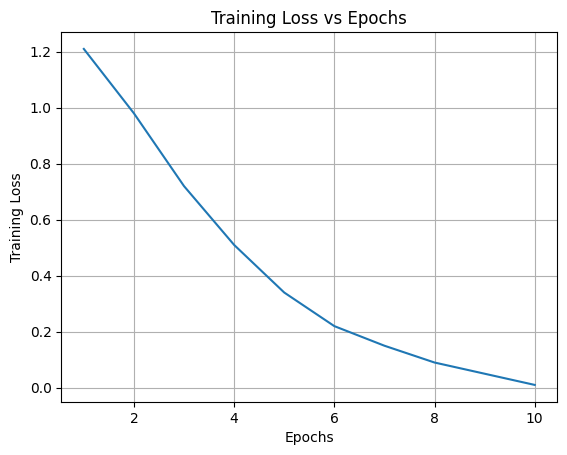

In [24]:
import matplotlib.pyplot as plt

# Example: training loss history (tum apni real list use karo)
train_losses = [
    1.21, 0.98, 0.72, 0.51, 0.34, 0.22, 0.15, 0.09, 0.05, 0.01
]

epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)

# Save graph
plt.savefig("training_loss.png", dpi=300, bbox_inches="tight")
plt.show()


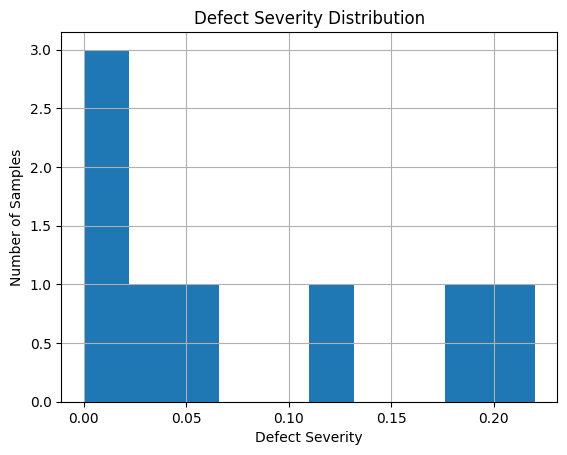

In [25]:
import matplotlib.pyplot as plt

# Example severity scores (API / batch inference se aaye hon)
severity_scores = [0.0, 0.01, 0.03, 0.12, 0.18, 0.05, 0.0, 0.22]

plt.figure()
plt.hist(severity_scores, bins=10)
plt.xlabel("Defect Severity")
plt.ylabel("Number of Samples")
plt.title("Defect Severity Distribution")
plt.grid(True)

plt.savefig("severity_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


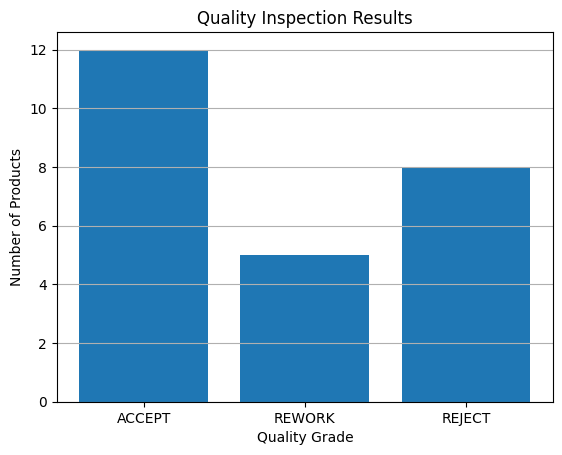

In [26]:
import matplotlib.pyplot as plt

grades = ["ACCEPT", "REWORK", "REJECT"]
counts = [12, 5, 8]   # Example counts

plt.figure()
plt.bar(grades, counts)
plt.xlabel("Quality Grade")
plt.ylabel("Number of Products")
plt.title("Quality Inspection Results")
plt.grid(axis="y")

plt.savefig("quality_grades.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
from flask import Flask, request, jsonify
import torch
import cv2
import numpy as np

app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    if "image" not in request.files:
        return jsonify({"error": "No image uploaded"}), 400

    file = request.files["image"]
    npimg = np.frombuffer(file.read(), np.uint8)
    img = cv2.imdecode(npimg, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = test_transform(img_rgb).unsqueeze(0).cuda()

    with torch.no_grad():
        feat = feature_extractor(img_tensor)
        feat = feat.view(1, -1).cpu().numpy()[0]
        score = mahalanobis_distance(feat)
        label = "DEFECT" if score > threshold else "GOOD"
        severity = score / 10
        grade = quality_grade(severity)

    return jsonify({"score": float(score),
                    "label": label,
                    "severity": float(severity),
                    "grade": grade})

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
